<a href="https://colab.research.google.com/github/KashishMaurya/Automate-Emotional-Analysis-of-Textual-Comments-and-Feedback/blob/main/Emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set Up Google Colab & Install Required Libraries**

Install in Colab

In [1]:
# Install Hugging Face Transformers & Datasets
!pip install -q transformers datasets

# Install PyTorch (comes preinstalled in Colab, but updated anyway)
!pip install -q torch torchvision torchaudio

# Install NLP tools and data handling libraries
!pip install -q scikit-learn pandas numpy nltk

# Optional: tqdm for progress bars
!pip install -q tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.9 MB/s eta 0:00:00


 Import the Libraries

In [2]:
# Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Dataset management
from datasets import load_dataset, Dataset, DatasetDict

# Torch for deep learning
import torch
from torch.utils.data import DataLoader

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Preprocessing & NLP
import pandas as pd
import numpy as np
import nltk
import re

# Download sentence tokenizer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Check Environment

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda




---



**Dataset Download and Exploration - GoEmotions**

Load the Dataset

In [4]:
from datasets import load_dataset

# Load the GoEmotions dataset
goemotions = load_dataset("go_emotions")

# It returns a DatasetDict with splits: train, validation, test
print(goemotions)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


Inspect the Data

In [5]:
# Print a few examples from the training set
goemotions['train'][0:3]


{'text': ["My favourite food is anything I didn't have to cook myself.",
  'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
  'WHY THE FUCK IS BAYLESS ISOING'],
 'labels': [[27], [27], [2]],
 'id': ['eebbqej', 'ed00q6i', 'eezlygj']}

load the label-to-emotion mapping

In [6]:
# Load label names
label_list = goemotions['train'].features['labels'].feature.names
print(label_list)


['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']




---



**Text Cleaning and Preprocessing**

Slang & Abbreviation Dictionary

In [7]:
# Basic slang/abbreviation dictionary
slang_dict = {
    "2mrw": "tomorrow",
    "2morrow": "tomorrow",
    "gr8": "great",
    "b4": "before",
    "u": "you",
    "r": "are",
    "ur": "your",
    "nxt": "next",
    "thx": "thanks",
    "pls": "please",
    "plz": "please",
    "luv": "love",
    "omg": "oh my god",
    "idk": "i do not know",
    "btw": "by the way",
    "lmao": "laughing my ass off",
    "lol": "laughing out loud",
}


Preprocessing Function

In [8]:
import re

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Replace slang
    for slang, replacement in slang_dict.items():
        pattern = r'\b' + re.escape(slang) + r'\b'
        text = re.sub(pattern, replacement, text)

    # Remove unwanted characters (keep basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", '', text)

    # Remove multiple spaces
    text = ' '.join(text.split())

    return text


Apply to Dataset(check)

In [9]:
sample_text = "I'm sooo gr8!!! See u 2mrw, ok??? $$$ :D"
print("Before:", sample_text)
print("After: ", preprocess_text(sample_text))


Before: I'm sooo gr8!!! See u 2mrw, ok??? $$$ :D
After:  i'm sooo great!!! see you tomorrow, ok??? d


Apply to entire dataset

In [10]:
# Define a wrapper function for mapping
def clean_examples(example):
    example['text'] = preprocess_text(example['text'])
    return example

# Apply cleaning to all splits
goemotions = goemotions.map(clean_examples)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]



---



**Tokenization and Label Encoding for BERT**

Load the BERT Tokenizer

In [11]:
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Define Tokenization Function

In [12]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",       # Pad shorter sequences
        truncation=True,            # Truncate longer ones
        max_length=128,             # Limit to 128 tokens
    )


Apply this to the whole dataset:

In [13]:
# Tokenize all splits
tokenized_datasets = goemotions.map(tokenize_function, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Installs all necessary libraries and handles the Weights & Biases login process.

In [14]:
# Install all required libraries
!pip install -q transformers datasets evaluate wandb

# W&B Login
import wandb
# wandb.login()

# Import all necessary libraries for the notebook
import numpy as np
import torch
import torch.nn as nn
from typing import List, Dict
from datasets import load_dataset
from transformers import (
    BertConfig,
    BertForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00


One-Hot Encoding Function

In [15]:
import torch

def create_one_hot_labels(example, num_labels=28):
    # Initialize a zero vector of the size of our label space
    labels = [0.0] * num_labels

    # Set the index to 1.0 for each emotion present in the example
    for label_index in example['labels']:
        labels[label_index] = 1.0

    # Replace the original list of labels with our one-hot vector
    return {'labels': labels}

Apply the Function to Your Dataset

In [16]:
# Assuming `num_labels` is already defined from a previous step
# (e.g., num_labels = len(goemotions['train'].features['labels'].feature.names))
one_hot_datasets = tokenized_datasets.map(create_one_hot_labels, batched=False)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Custom Model and Data Collator

In [17]:
# Custom model class for multi-label classification with BCEWithLogitsLoss
class CustomBertForMultiLabel(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.loss_fct = nn.BCEWithLogitsLoss()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Filter out the unexpected 'num_items_in_batch' argument from the Trainer
        if 'num_items_in_batch' in kwargs:
            del kwargs['num_items_in_batch']

        # Pass remaining arguments to the base model's forward method
        output = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None, **kwargs)
        logits = output.logits

        # Calculate the custom loss if labels are provided
        if labels is not None:
            labels = labels.float()
            loss = self.loss_fct(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

import numpy as np
import torch
from transformers import DataCollatorWithPadding
from typing import List, Dict

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features: List[Dict[str, any]]) -> Dict[str, torch.Tensor]:
        # Pop labels, text, and id to handle them separately
        labels = [feature.pop('labels') for feature in features]

        # Safely remove keys that might or might not be in the dataset
        if 'text' in features[0]:
            _ = [feature.pop('text') for feature in features]
        if 'id' in features[0]:
            _ = [feature.pop('id') for feature in features]

        # Use the base class to pad the text inputs
        batch = super().__call__(features)

        # FIX: Convert the list of labels to a NumPy array first
        # This handles any nested list issues and ensures a uniform shape
        labels_array = np.array(labels)

        # Now, create the tensor from the NumPy array
        batch['labels'] = torch.tensor(labels_array, dtype=torch.float32)

        return batch

print("Loading model configuration...")
num_labels = len(goemotions['train'].features['labels'].feature.names)
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels, problem_type="multi_label_classification")

print("Initializing custom multi-label BERT model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomBertForMultiLabel.from_pretrained("bert-base-uncased", config=config)
model.to(device)

print("\nCreating custom data collator...")
data_collator = CustomDataCollator(tokenizer=tokenizer)

Loading model configuration...
Initializing custom multi-label BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertForMultiLabel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating custom data collator...


Cross-check the Data Collator

In [18]:
print("--- Verifying Data Collator Output ---")

# Take a small batch of examples from the training dataset
# The data collator needs a list of dictionaries, not a single tensor
test_batch = [tokenized_datasets['train'][i] for i in range(4)]

# Pass the batch to your custom data collator
processed_batch = data_collator(test_batch)

# Print the keys in the processed batch to see what the Trainer will receive
print("\nKeys in the processed batch:", processed_batch.keys())

# Now, inspect the 'labels' tensor in the processed batch
print("\nLabels tensor in the processed batch:")
print(processed_batch['labels'])
print("Shape of labels tensor:", processed_batch['labels'].shape)
print("Dtype of labels tensor:", processed_batch['labels'].dtype)

# The expected Dtype should be torch.float32.
# If it is, the fix has worked and you can proceed.
assert processed_batch['labels'].dtype == torch.float32
print("\nVerification successful! Labels are of Dtype:", processed_batch['labels'].dtype)

--- Verifying Data Collator Output ---

Keys in the processed batch: KeysView({'input_ids': tensor([[  101,  2026,  8837,  2833,  2003,  2505,  1045,  2134,  1005,  1056,
          2031,  2000,  5660,  2870,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Define metrics and TrainingArguments

In [19]:
# Install scikit-learn for robust multi-label metric calculation
!pip install -q scikit-learn

import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import TrainingArguments

# Define the compute_metrics function using scikit-learn
def compute_metrics(pred):
    logits, labels = pred
    # Apply sigmoid to logits to get probabilities
    # Use np.exp to avoid torch dependency here, as pred is a numpy array
    probs = 1 / (1 + np.exp(-logits))
    # Binarize the probabilities to get multi-hot predictions
    preds = (probs > 0.5).astype(int)

    # The accuracy_score function in scikit-learn for multi-label
    # calculates "subset accuracy," where all labels must match exactly.
    # This is often too strict, so macro-averaged precision, recall, and f1 are better.
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "f1": f1_score(labels, preds, average="macro", zero_division=0),
    }

# Define the training arguments
print("Defining TrainingArguments...")
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="wandb"
)

Defining TrainingArguments...


Trainer Instantiation and Training

In [20]:
print("Instantiating Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=one_hot_datasets['train'],
    eval_dataset=one_hot_datasets['validation'],
    # Use the custom data collator to handle padding and labels
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f"\nStarting training on device: {device}...")
trainer.train()

print("\nTraining complete!")

Instantiating Trainer...

Starting training on device: cuda...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kashish-18 (kashish-18-amity-online) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.092900,0.093672,0.377995,0.411007,0.229544,0.262128
2,0.082000,0.086071,0.435127,0.558360,0.317943,0.375546
3,0.074100,0.086065,0.456137,0.535835,0.343717,0.396110



Training complete!


**Model Evaluation, Testing & Emotion Prediction**

Evaluate the Model on Validation Data

In [21]:
# Evaluate on validation set
eval_result = trainer.evaluate()
print(eval_result)

{'eval_loss': 0.08606517314910889, 'eval_accuracy': 0.45613711758201253, 'eval_precision': 0.535834961627294, 'eval_recall': 0.34371653435463084, 'eval_f1': 0.3961095064746139, 'eval_runtime': 40.8488, 'eval_samples_per_second': 132.831, 'eval_steps_per_second': 8.323, 'epoch': 3.0}


In [22]:
from sklearn.metrics import classification_report

# Get predictions on validation set
# Use the correct variable name for the validation dataset
predictions = trainer.predict(one_hot_datasets['validation'])
logits = predictions.predictions
labels = predictions.label_ids

# Apply sigmoid and threshold
probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.5).astype(int)

# Get label names
label_names = goemotions['train'].features['labels'].feature.names

# Print classification report
print(classification_report(labels, preds, target_names=label_names, zero_division=0))

                precision    recall  f1-score   support

    admiration       0.73      0.74      0.74       488
     amusement       0.76      0.79      0.77       303
         anger       0.56      0.42      0.48       195
     annoyance       0.59      0.09      0.15       303
      approval       0.52      0.20      0.29       397
        caring       0.75      0.35      0.47       153
     confusion       0.60      0.29      0.39       152
     curiosity       0.54      0.44      0.48       248
        desire       0.68      0.42      0.52        77
disappointment       0.45      0.06      0.11       163
   disapproval       0.56      0.24      0.33       292
       disgust       0.68      0.31      0.43        97
 embarrassment       0.00      0.00      0.00        35
    excitement       0.60      0.16      0.25        96
          fear       0.77      0.44      0.56        90
     gratitude       0.95      0.89      0.91       358
         grief       0.00      0.00      0.00  

**Emotion Prediction on Custom Sentences**

In [23]:
def predict_emotions(text, threshold=0.3):
    from transformers import BertTokenizer
    import torch

    # Preprocess the text
    clean_text = preprocess_text(text)

    # Tokenize and prepare input
    inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # Run the model
    with torch.no_grad():
        logits = model(**inputs)['logits']
        probs = torch.sigmoid(logits)

        print("\n--- Prediction Probabilities ---")
        for i, prob in enumerate(probs[0].cpu().numpy()):
            if prob > 0.1:  # Print only top ones
                print(f"{label_names[i]}: {prob:.3f}")

        # Apply threshold to get multi-label prediction
        predicted = (probs > threshold).int()

    # Get predicted label indices
    predicted_indices = predicted[0].nonzero().flatten().tolist()
    predicted_labels = [label_names[i] for i in predicted_indices]

    # Final output
    if predicted_labels:
        print("\nPredicted emotions:", predicted_labels)
    else:
        print("\nNo emotions predicted. Try lowering threshold or re-training.")

    return predicted_labels

# ✅ Example test
sample = "I'm so excited but also a little nervous about tomorrow!"
predict_emotions(sample)



--- Prediction Probabilities ---
excitement: 0.239
fear: 0.314
joy: 0.164

Predicted emotions: ['fear']


['fear']

**Generate Charts & Graphs for Insights**

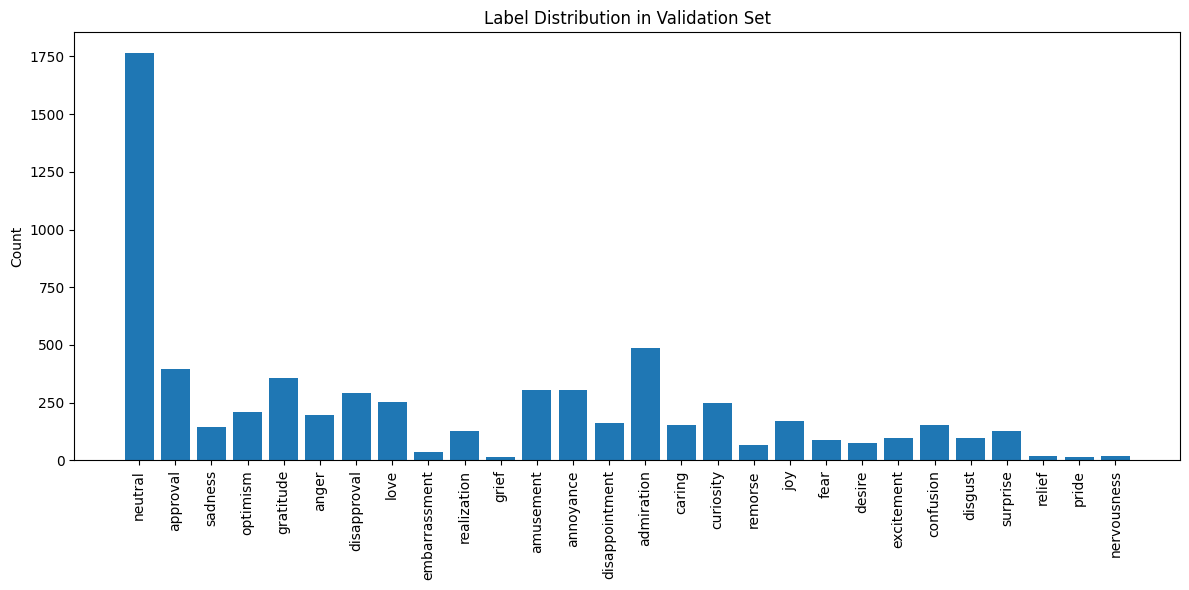

In [24]:
import matplotlib.pyplot as plt

# Flatten all label lists
all_labels = goemotions["validation"]["labels"]
flat_labels = [label for sublist in all_labels for label in sublist]

# Count
from collections import Counter
label_counts = Counter(flat_labels)
labels = [label_names[i] for i in label_counts.keys()]
values = label_counts.values()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.title("Label Distribution in Validation Set")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.tight_layout()
plt.show()


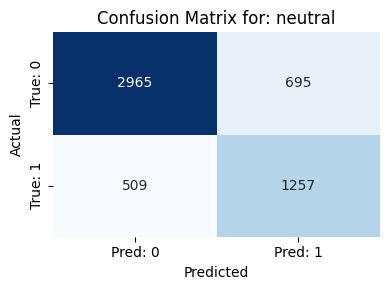

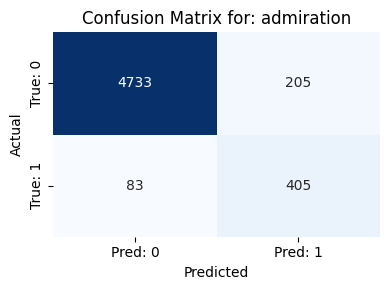

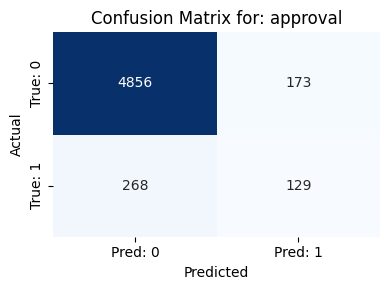

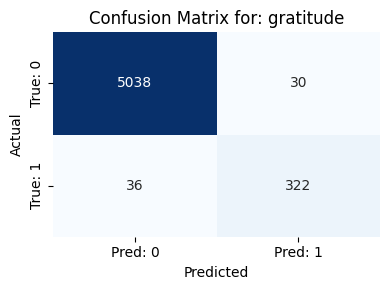

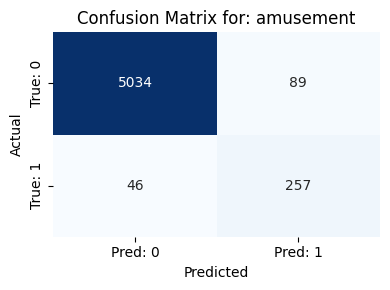

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from collections import Counter

# Step 1: Predict on the validation set
# Use the correct validation dataset with one-hot encoded labels
predictions = trainer.predict(one_hot_datasets['validation'])
logits = predictions.predictions
true_labels = predictions.label_ids

# Step 2: Get predicted labels using sigmoid + threshold
threshold = 0.3
probs = 1 / (1 + np.exp(-logits))
preds = (probs > threshold).astype(int)

# Step 3: Choose top N frequent labels
# Use the original dataset to find the most common labels, not the one-hot version
flat_labels = [label for sample in goemotions['validation']['labels'] for label in sample]
label_counts = Counter(flat_labels)
top_n = 5
top_labels = [label_names[i] for i, _ in label_counts.most_common(top_n)]
top_indices = [label_names.index(lbl) for lbl in top_labels]

# Step 4: Get confusion matrices for top labels
mcm = multilabel_confusion_matrix(true_labels, preds)

# Step 5: Plot each as heatmap
for i, idx in enumerate(top_indices):
    cm = mcm[idx]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"])
    plt.title(f'Confusion Matrix for: {label_names[idx]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


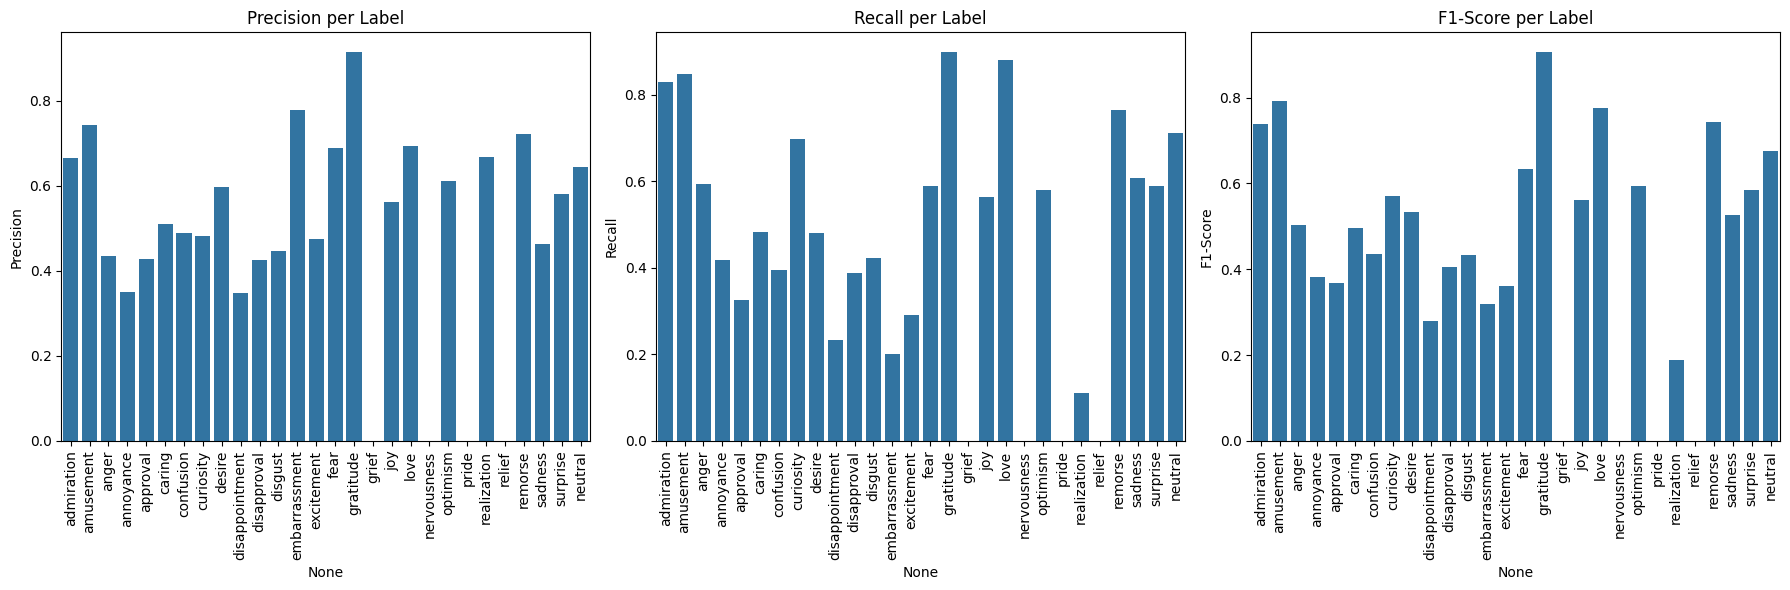

In [26]:
import pandas as pd

# Get the classification report as a dictionary
report = classification_report(true_labels, preds, target_names=label_names, output_dict=True)

# Convert to DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Exclude 'accuracy', 'macro avg', and 'weighted avg' from the plot
df_plot = df_report.loc[label_names]

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision
sns.barplot(x=df_plot.index, y='precision', data=df_plot, ax=axes[0])
axes[0].set_title('Precision per Label')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylabel('Precision')

# Plot Recall
sns.barplot(x=df_plot.index, y='recall', data=df_plot, ax=axes[1])
axes[1].set_title('Recall per Label')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylabel('Recall')

# Plot F1-Score
sns.barplot(x=df_plot.index, y='f1-score', data=df_plot, ax=axes[2])
axes[2].set_title('F1-Score per Label')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()


In [27]:
import torch
import numpy as np

def predict_custom_text(text, model, tokenizer, label_names, threshold=0.5):
    """
    Predicts emotions for a custom text input.
    """
    # 1. Preprocess the text using the same function from earlier
    processed_text = preprocess_text(text)

    # 2. Tokenize the text
    inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # 3. Move inputs to the correct device (cuda or cpu)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 4. Get model logits (predictions)
    with torch.no_grad():
        # Correctly access the logits from the returned dictionary
        logits = model(**inputs)['logits']

    # 5. Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(logits).cpu().numpy().flatten()

    # 6. Apply threshold to get binary predictions
    preds = (probs > threshold).astype(int)

    # 7. Map predictions back to label names
    predicted_emotions = {
        label_names[i]: probs[i] for i, p in enumerate(preds) if p == 1
    }

    return predicted_emotions

# Example usage:
custom_text = "I'm so excited about the new project! This is going to be amazing!"
predicted_emotions = predict_custom_text(custom_text, model, tokenizer, label_names, threshold=0.5)

print(f"Text: '{custom_text}'")
print("\nPredicted Emotions:")
for emotion, prob in predicted_emotions.items():
    print(f"- {emotion.capitalize()}: {prob:.4f}")

Text: 'I'm so excited about the new project! This is going to be amazing!'

Predicted Emotions:
- Excitement: 0.7079


In [28]:
# Interactive loop for custom input
while True:
    user_input = input("\nEnter text to analyze (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        print("Exiting...")
        break

    if user_input.strip() == "":
        print("Please enter some text.")
        continue

    predicted_emotions = predict_custom_text(user_input, model, tokenizer, label_names, threshold=0.5)

    print("\nPredicted Emotions:")
    if not predicted_emotions:
        print("No emotions detected above the threshold.")
    else:
        for emotion, prob in predicted_emotions.items():
            print(f"- {emotion.capitalize()}: {prob:.4f}")


Enter text to analyze (or 'quit' to exit): my name is kashish maurya, i want to push this whole project to github.

Predicted Emotions:
- Desire: 0.6133

Enter text to analyze (or 'quit' to exit): my name is kashish maurya

Predicted Emotions:
- Neutral: 0.6296

Enter text to analyze (or 'quit' to exit): i want to push this whole project to github

Predicted Emotions:
- Desire: 0.5490

Enter text to analyze (or 'quit' to exit): ok bye

Predicted Emotions:
- Neutral: 0.9393

Enter text to analyze (or 'quit' to exit): quit
Exiting...
